In [1]:
import requests
import json
import pandas as pd  
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy import optimize
%matplotlib inline

# API Call for data collection

In [2]:

url = 'https://v1.api.covindia.com/covindia-raw-data'
raw_data = requests.get(url=url).json()
# Next line is just to change the type of keys from string to int
# This is required for making the dataframe automatically
raw_data = {int(old_key): val for old_key, val in raw_data.items()}
#print(raw_data)

In [3]:
raw_data_df = pd.DataFrame.from_dict(raw_data, orient='index')
raw_data_df  = raw_data_df [['date','time','district','state','infected','death','source']]
raw_data_df["date"] = pd.to_datetime(raw_data_df["date"],dayfirst=True)
raw_data_df.to_csv('raw_data.csv', index = False)
raw_data_df.head()

,date,time,district,state,infected,death,source
0,2020-02-03,0:00,Kannur,Kerala,1,0,http://dhs.kerala.gov.in/%e0%b4%a1%e0%b5%86%e0...
1,2020-03-02,0:00,Delhi,Delhi,1,0,https://en.wikipedia.org/wiki/2020_coronavirus...
2,2020-03-02,0:00,Delhi,Delhi,5,0,https://en.wikipedia.org/wiki/2020_coronavirus...
3,2020-03-02,0:00,Delhi,Delhi,1,0,https://en.wikipedia.org/wiki/2020_coronavirus...
4,2020-03-02,19:53,Hyderabad,Telangana,5,0,NA


In [4]:
# Finding the total infected and death
print('Total Infected : ' + str(raw_data_df['infected'].sum()))
print('Total Death : ' + str(raw_data_df['death'].sum()))

Total Infected : 34686
Total Death : 1175


In [5]:
# Aggregating the data daywise and districtwise
dist_day_df = raw_data_df.groupby(['date', 'district'], as_index=False)['infected','death'].sum()
dist_day_df = dist_day_df.sort_values('date', ascending = True)
dist_day_df.head()

,date,district,infected,death
0,2020-02-03,Kannur,1,0
1,2020-03-02,Delhi,7,0
2,2020-03-02,Hyderabad,5,0
3,2020-03-04,DIST_NA,14,0
4,2020-03-04,Jaipur,1,0


In [6]:
# Aggregating the data daywise and statewise
state_day_df = raw_data_df.groupby(['date', 'state'], as_index=False)['infected','death'].sum()
state_day_df.head()

,date,state,infected,death
0,2020-02-03,Kerala,1,0
1,2020-03-02,Delhi,7,0
2,2020-03-02,Telangana,5,0
3,2020-03-04,Haryana,14,0
4,2020-03-04,Rajasthan,1,0


# Testing for one State: Telangana

In [7]:
telangana_df=state_day_df[state_day_df['state']=='Telangana']

In [8]:
telangana_df=telangana_df[(telangana_df['date'] > '2020-03-13')] # Start Date
telangana_df=telangana_df.reset_index()
telangana_df=telangana_df.drop(['index'],axis=1)
telangana_df.head()

,date,state,infected,death
0,2020-03-14,Telangana,1,0
1,2020-03-15,Telangana,1,0
2,2020-03-17,Telangana,2,0
3,2020-03-18,Telangana,4,0
4,2020-03-19,Telangana,3,0


In [9]:
telangana_df['date']=telangana_df['date'].apply(lambda x: x.date()).apply(str) #formatting the date

In [10]:
cumalative_sum=telangana_df.infected.cumsum()
telangana_df['cumalative_infected']=cumalative_sum
telangana_df=telangana_df.set_index('date')

In [11]:
telangana_df.tail()

,state,infected,death,cumalative_infected
date,,,,
2020-04-25,Telangana,7,0,985
2020-04-26,Telangana,11,0,996
2020-04-27,Telangana,2,0,998
2020-04-28,Telangana,6,0,1004
2020-04-29,Telangana,7,0,1011


#### Infected - Cases recored on date
#### Cumalative infected- Total Cases in the state

## Graph

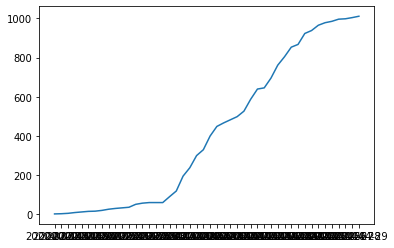

In [12]:
plt.plot(telangana_df['cumalative_infected'])

# Fitting of Logistic and Gaussian Curves

#### Logistic Curve: Used for prediction for total number of cases
#### Gaussian Curve: Used for prediction for number of new cases per day

In [13]:
def utils_plot_parametric(dtf,fore_index ,zoom=30, figsize=(15,5),new=False):
    
    
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    
  
    
    if new: #Checks if for Gaussian or Logistic Curve
        dtf['ts'].plot.bar(ax=ax[0],color='black',title="Parametric Fitting")
    else:
        dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
        
        
    dtf["model"].plot(ax=ax[0], color="blue")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    
    
   
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    
    
    if new:
        dtf.loc[zoom_idx:]['ts'].plot.bar(ax=ax[1],color='black',linestyle='None', title="Zoom on the last "+str(zoom)+" observations")
    else:
        dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="blue")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    
    
    
        
    if not new:
        plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    else:
        plt.setp(ax[0].get_xticklabels(), rotation=90, horizontalalignment='right',fontsize=3)

        
    plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=8)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]








In [14]:

def forecast_curve(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5),newcases=False):
    
    
    ## for Fitting
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    
    
    ## Marking the index for prediction
    start=dtf.index[-1]
    
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    #print(index)
    fore_index=index
    index = index[1:]
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    

    if newcases:
        utils_plot_parametric(dtf,fore_index,zoom=zoom,new=True)
    else:
        utils_plot_parametric(dtf,fore_index, zoom=zoom)
        
  
    return dtf

#### Forecast unknown future.
#### Parameter
   ####  :param ts: pandas series
   ####  :param f: function
   ####  :param model: list of optim params
   ####  :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
   ####  :param zoom: for plotting


In [15]:
def get_graphs_per_state(state):
    
    
    def logistic_f(X, c, k, m):  #Logistic Function
        y = c / (1 + np.exp(-k*(X-m)))
        return y




    def gaussian_f(X, a, b, c):  #Gaussian Function
        y = a * np.exp(-0.5 * ((X-b)/c)**2)
        return y
    
    
    
    cur_state_df=state_day_df[state_day_df['state']==state]
    cur_state_df=cur_state_df[(cur_state_df['date'] > '2020-03-13')]
    cur_state_df=cur_state_df.reset_index()
    cur_state_df=cur_state_df.drop(['index'],axis=1)
    
    cur_state_df['date']=cur_state_df['date'].apply(lambda x: x.date()).apply(str)
    
    
    cumalative_sum=cur_state_df.infected.cumsum()
    cur_state_df['cumalative_infected']=cumalative_sum
    cur_state_df=cur_state_df.set_index('date')
    #print(cur_state_df)

    
    
    #Curve Fitting
    
    logistic_model, cov = optimize.curve_fit(logistic_f,xdata=np.arange(len(cur_state_df['cumalative_infected'])),
                                             ydata=cur_state_df['cumalative_infected'].values, maxfev=10000,
                                             p0=[np.max(cur_state_df['cumalative_infected']), 1, 1])
    
    gaussian_model, cov = optimize.curve_fit(gaussian_f, xdata=np.arange(len(cur_state_df['infected'])),
                                             ydata=cur_state_df['infected'].values,maxfev=10000,
                                             p0=[1,np.mean(cur_state_df['infected']), 1])
    
    
    
    #Calling for predictions and Plotting

    preds_total = forecast_curve(cur_state_df["cumalative_infected"], logistic_f, logistic_model, 
                       pred_ahead=20, freq="D", zoom=7)
    
    
    preds_new = forecast_curve(cur_state_df["infected"], gaussian_f, gaussian_model, 
                       pred_ahead=20, freq="D", zoom=7,newcases=True)
    
    return (preds_new,preds_total)
    
    
    
    

C:\Users\msais\Anaconda3\envs\gg\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


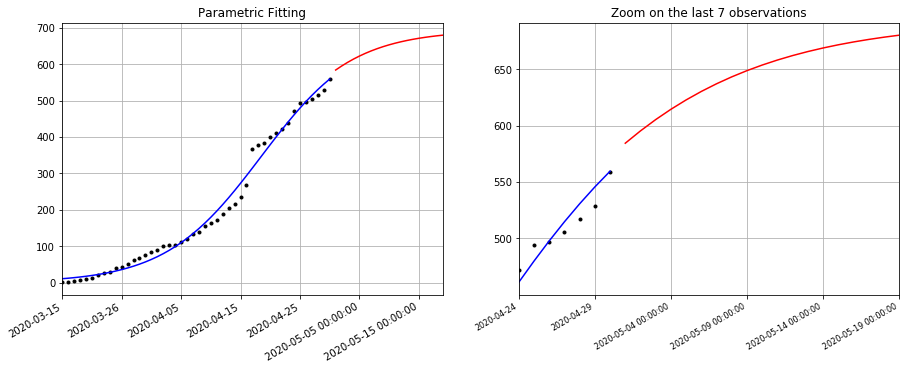

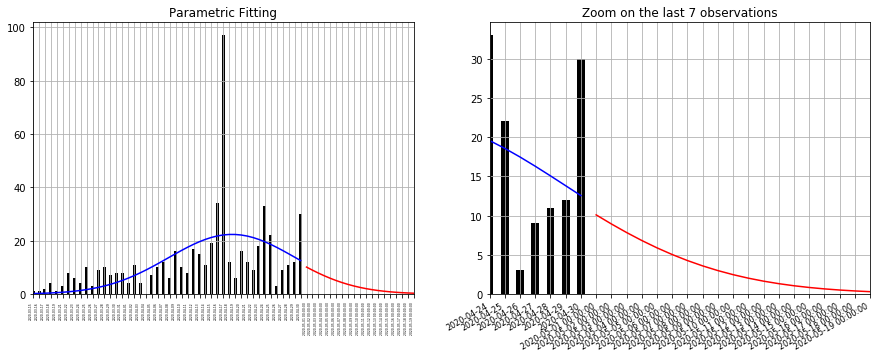

In [16]:
preds_new,preds_total=get_graphs_per_state('Karnataka')

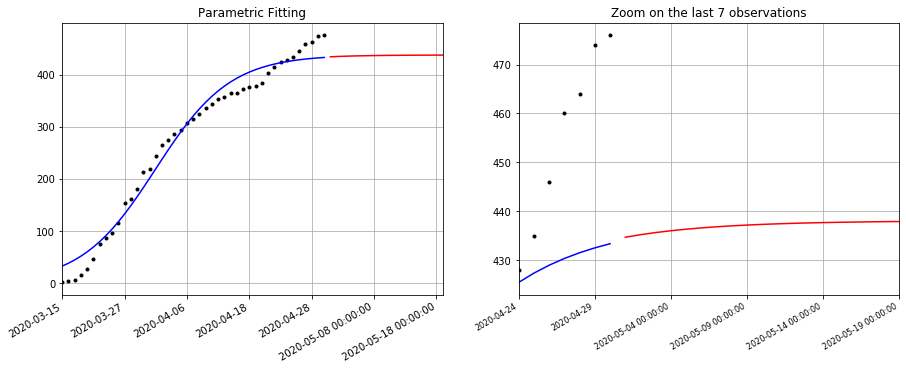

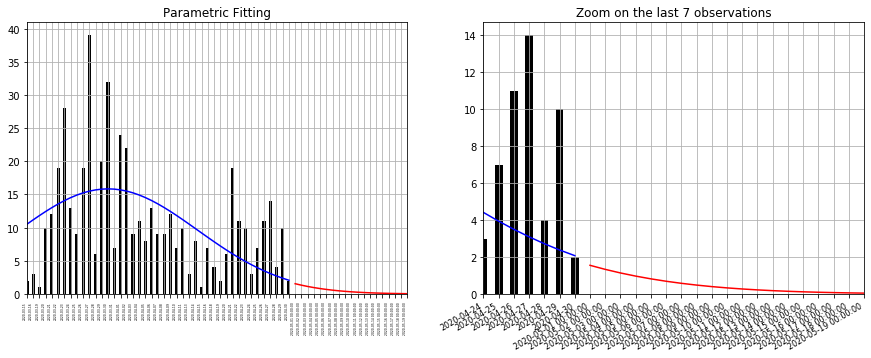

In [17]:
preds_new,preds_total=get_graphs_per_state('Kerala')

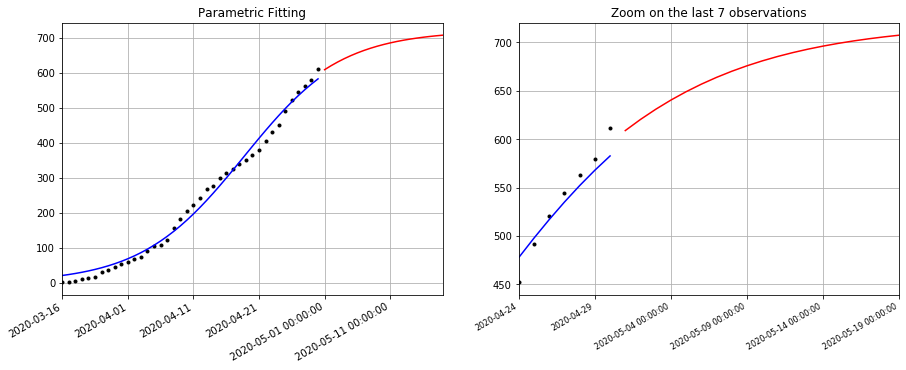

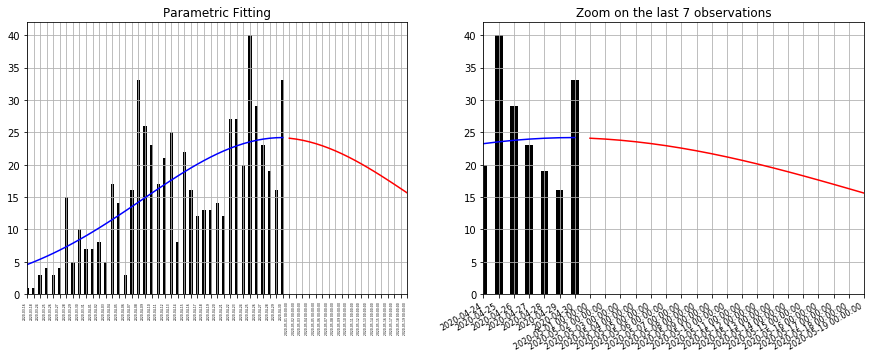

In [18]:
preds_new,preds_total=get_graphs_per_state('Jammu and Kashmir')

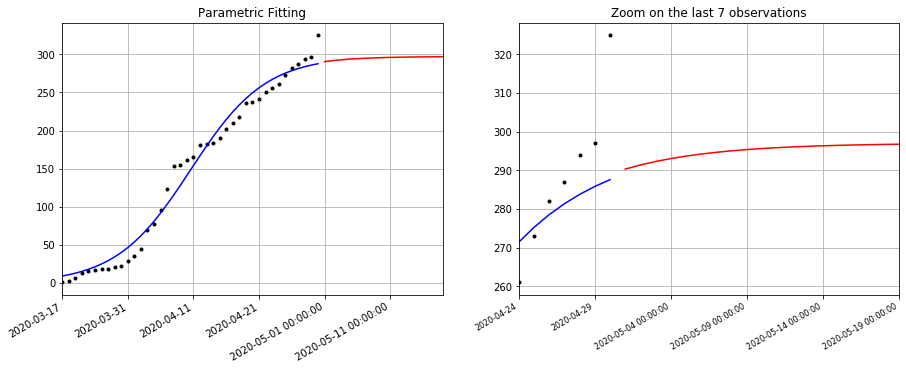

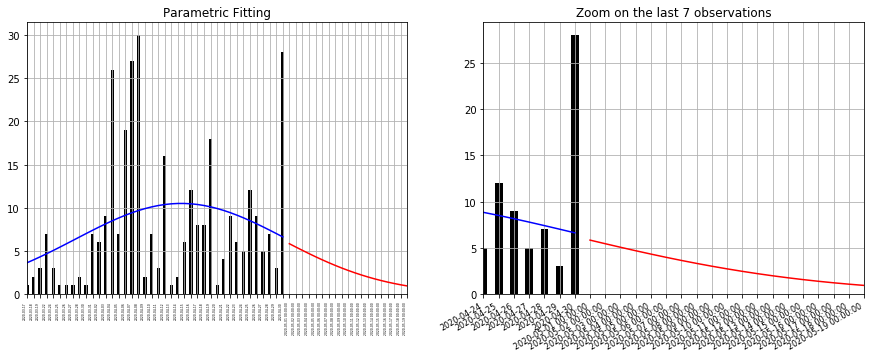

In [19]:
preds_new,preds_total=get_graphs_per_state('Haryana')

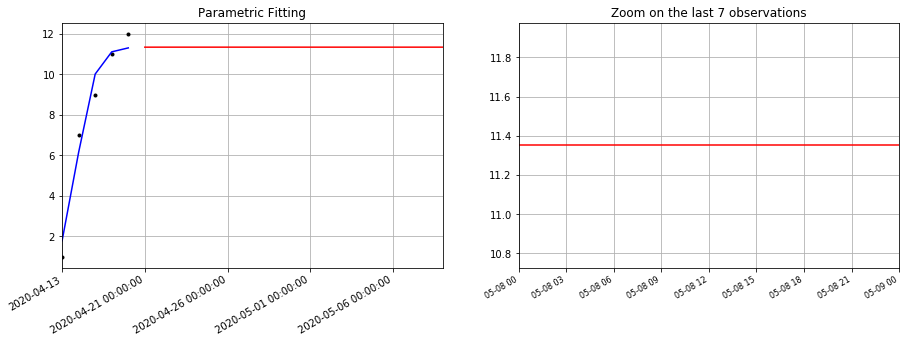

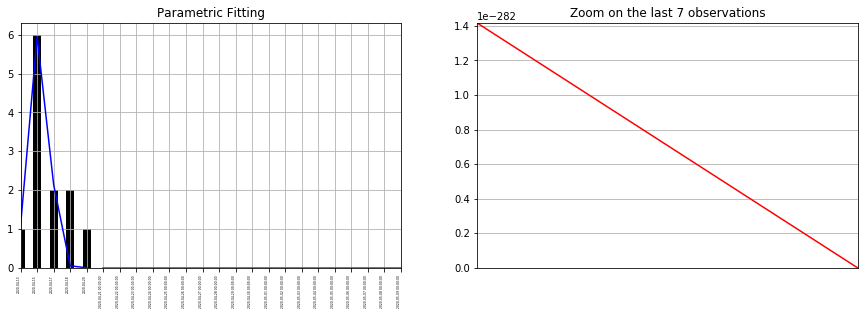

In [20]:
preds_new,preds_total=get_graphs_per_state('Meghalaya')

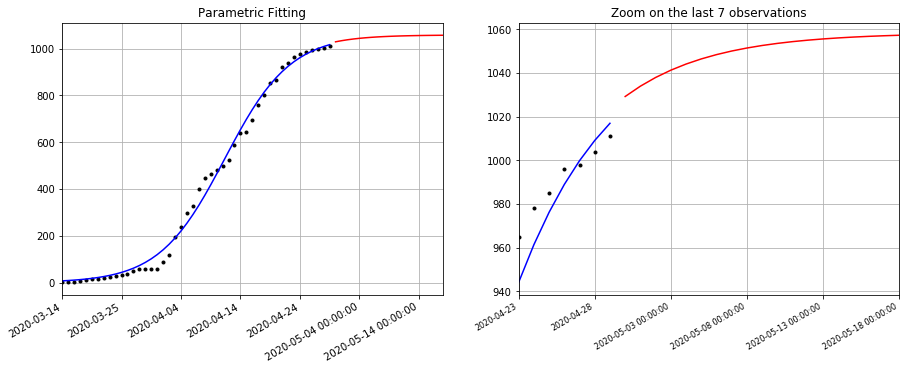

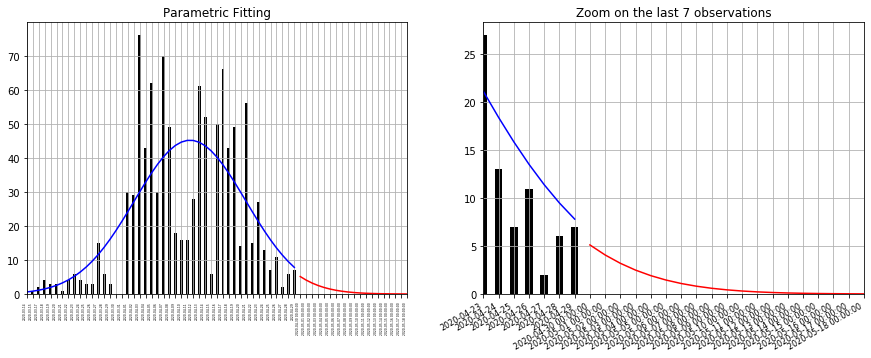

In [21]:
preds_new,preds_total=get_graphs_per_state('Telangana')

In [22]:
preds_new

,forecast,model,ts,residuals,conf_int_low,conf_int_up
2020-03-14,NaN,0.612856,1.0,0.387144,NaN,NaN
2020-03-15,NaN,0.833468,1.0,0.166532,NaN,NaN
2020-03-17,NaN,1.120641,2.0,0.879359,NaN,NaN
2020-03-18,NaN,1.489672,4.0,2.510328,NaN,NaN
2020-03-19,NaN,1.957772,3.0,1.042228,NaN,NaN
2020-03-20,NaN,2.543787,3.0,0.456213,NaN,NaN
2020-03-21,NaN,3.267732,1.0,-2.267732,NaN,NaN
2020-03-22,NaN,4.150105,4.0,-0.150105,NaN,NaN
2020-03-23,NaN,5.210974,6.0,0.789026,NaN,NaN
2020-03-24,NaN,6.468831,4.0,-2.468831,NaN,NaN


In [23]:
preds_total

,forecast,model,ts,residuals,conf_int_low,conf_int_up
2020-03-14,NaN,7.350336,1.0,-6.350336,NaN,NaN
2020-03-15,NaN,8.800181,2.0,-6.800181,NaN,NaN
2020-03-17,NaN,10.533139,4.0,-6.533139,NaN,NaN
2020-03-18,NaN,12.603259,8.0,-4.603259,NaN,NaN
2020-03-19,NaN,15.074376,11.0,-4.074376,NaN,NaN
2020-03-20,NaN,18.021654,14.0,-4.021654,NaN,NaN
2020-03-21,NaN,21.533278,15.0,-6.533278,NaN,NaN
2020-03-22,NaN,25.712251,19.0,-6.712251,NaN,NaN
2020-03-23,NaN,30.678244,25.0,-5.678244,NaN,NaN
2020-03-24,NaN,36.569391,29.0,-7.569391,NaN,NaN
